# Learning, Fraud Detection - dropped too many nulls

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc

%matplotlib inline

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn import metrics

from IPython.display import HTML

In [73]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [74]:
train_identity = pd.read_csv('data/train_identity.csv')
print("Train identity:{}".format(train_identity.shape))
train_transaction = pd.read_csv('data/train_transaction.csv')
print("Train transaction:{}".format(train_transaction.shape))

Train identity:(144233, 41)
Train transaction:(590540, 394)


In [75]:
train_identity = reduce_mem_usage(train_identity)
train_transaction = reduce_mem_usage(train_transaction)

Memory usage of dataframe is 45.12 MB --> 25.86 MB (Decreased by 42.7%)
Memory usage of dataframe is 1775.15 MB --> 542.35 MB (Decreased by 69.4%)


In [76]:
# Join Transaction and Identity dataframes
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


## Feature Engineering

In [77]:
# Delete identity and transaction dataframes from memory
del train_identity, train_transaction
gc.collect()

5296

In [78]:
# Find the columns with more than 95% of rows having NaN
# and dropp them
many_null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.99]
len(many_null_cols)
train = train.drop(many_null_cols, axis=1)


In [79]:
print('many_null_cols: {}'.format(many_null_cols))

many_null_cols: ['id_07', 'id_08', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']


In [80]:
# http://localhost:8888/notebooks/IEEE-CIS%20Fraud%20Detection%20_%20EDA.ipynb
import datetime

START_DATE = '2017-11-30'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train['Date'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
train['_ymd'] = train['Date'].dt.year.astype(str) + '-' + train['Date'].dt.month.astype(str) + '-' + train['Date'].dt.day.astype(str)
train['_year_month'] = train['Date'].dt.year.astype(str) + '-' + train['Date'].dt.month.astype(str)
train['_weekday'] = train['Date'].dt.dayofweek
train['_hour'] = train['Date'].dt.hour
train['_day'] = train['Date'].dt.day


In [81]:
# https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
# id_30 OS
train.loc[train['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
train.loc[train['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
train.loc[train['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
train.loc[train['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
train['id_30'].fillna("NAN", inplace=True)

In [82]:
train['id_30'].value_counts()

NAN        512975
Windows     36739
iOS         19782
Mac         13580
Android      6303
Linux        1136
other          15
func           10
Name: id_30, dtype: int64

In [83]:
# https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
# id_31 Browser
train.loc[train['id_31'].str.contains('chrome', na=False), 'id_31'] = 'Chrome'
train.loc[train['id_31'].str.contains('firefox', na=False), 'id_31'] = 'Firefox'
train.loc[train['id_31'].str.contains('safari', na=False), 'id_31'] = 'Safari'
train.loc[train['id_31'].str.contains('edge', na=False), 'id_31'] = 'Edge'
train.loc[train['id_31'].str.contains('ie', na=False), 'id_31'] = 'IE'
train.loc[train['id_31'].str.contains('samsung', na=False), 'id_31'] = 'Samsung'
train.loc[train['id_31'].str.contains('opera', na=False), 'id_31'] = 'Opera'
train['id_31'].fillna("NAN", inplace=True)
train.loc[train.id_31.isin(train.id_31.value_counts()[train.id_31.value_counts() < 200].index), 'id_31'] = "Others"
train['id_31'].value_counts()

NAN        450258
Chrome      76059
Safari      37281
IE          10018
Firefox      7012
Edge         6401
Samsung      2044
Others        706
Opera         449
other         312
Name: id_31, dtype: int64

In [84]:
train.drop('TransactionID', axis=1, inplace=True)
train.drop('TransactionDT', axis=1, inplace=True)
train.drop('_ymd', axis=1, inplace=True)
train.drop('_year_month', axis=1, inplace=True)
train.drop('Date', axis=1, inplace=True)

In [85]:
# Apply LabelEncoder to the categorical columns
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 
            'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 
            'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4',
            'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2','P_emaildomain',
            'R_emaildomain', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 
            'M8', 'M9']
for col in cat_cols:
    if col in train.columns:
        le = preprocessing.LabelEncoder()
        le.fit(list(train[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))

In [86]:
# Separate the data set with Features and Labels
y = train['isFraud']
X = train.drop('isFraud', axis=1)

del train
gc.collect()

200

In [87]:
# Split the data set into the Training and Test sets

from sklearn.model_selection import train_test_split

# Hold out test set from validation set for final test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split validation set for tuning
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [88]:
# Fill NaN with mean values of the column

X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)
X_val.fillna(X_test.mean(), inplace=True)
X_train.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,_weekday,_hour,_day
223517,52.937500,4,7199,446,42,4,108,2,67,65,...,4,2,2,2,2,2,1742,0,23,29
154151,44.593750,0,2289,389,42,4,119,1,332,74,...,4,2,2,2,2,2,1742,4,21,5
342405,7.855469,0,4787,213,42,2,106,2,332,74,...,4,0,0,1,0,0,1742,2,18,7
408458,792.000000,4,5732,389,42,4,108,2,78,65,...,4,2,2,2,2,2,1742,3,13,29
315183,254.000000,4,10118,217,42,4,58,2,175,65,...,4,2,2,2,2,2,1742,2,20,28


In [89]:
# Metrics functions
# Display Confusion Matrix
# Precision, Recall and F1 Scores

def show_scores(y_true, y_pred):
  
    print ("Confusion Matrix")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print ("true positive {0}, false positive: {1}\nfalse negative: {2}, true negative: {3}"
          .format(tp, fp, fn, tn))
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred) 
    print ("Precision: {0:.3f}, Recall: {1:.3f}".format(precision, recall))

    f1 = f1_score(y_true, y_pred)
    print ("F1 score: {0:.3f}".format(f1))
    
    
def show_auc_roc(label_data, prediction_data, metrics_title):
    fpr, tpr, thresholds = metrics.roc_curve(y_train, train_predictions)
    auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label='%s ROC curve (area = %.3f)'% (metrics_title, auc))
    plt.legend()
    plt.title('{} ROC curve'.format(metrics_title))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    
    print("{0} AUC: {1:.3f}".format(metrics_title, auc))

## Train and Test LightGBM model

In [90]:
%%time
# Train LGBM Model

import lightgbm as lgb

params={'learning_rate': 0.03,
        'objective': 'binary',
        'metric': 'auc',
        'max_bin': 256,
        'num_leaves': 256,
        'min_data_in_leaf': 10,
        'verbose': 1,
        'random_state': 42,
        'bagging_fraction': 0.85,
        'bagging_freq': 10,
        'feature_fraction': 0.9,
        'max_depth': 128,
       }

train_predictions = np.zeros(X_train.shape[0])
test_predictions = np.zeros(X_test.shape[0])

lgbm = lgb.LGBMClassifier(**params, n_estimators=3000)
# Train the model
lgbm.fit(X_train, y_train)


CPU times: user 2h 32min 31s, sys: 2min 53s, total: 2h 35min 24s
Wall time: 14min 20s


LGBMClassifier(bagging_fraction=0.85, bagging_freq=10, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
               importance_type='split', learning_rate=0.03, max_bin=256,
               max_depth=128, metric='auc', min_child_samples=20,
               min_child_weight=0.001, min_data_in_leaf=10, min_split_gain=0.0,
               n_estimators=3000, n_jobs=-1, num_leaves=256, objective='binary',
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
               verbose=1)

In [91]:
# Predict Training
train_preds = lgbm.predict(X_train, num_iteration=lgbm.best_iteration_)
show_scores(y_train, train_preds)

Confusion Matrix
true positive 13028, false positive: 1
false negative: 0, true negative: 364916
Precision: 1.000, Recall: 1.000
F1 score: 1.000


In [92]:
# Predict Validation
val_preds = lgbm.predict(X_val, num_iteration=lgbm.best_iteration_)
show_scores(y_val, val_preds)

Confusion Matrix
true positive 2050, false positive: 40
false negative: 1343, true negative: 91054
Precision: 0.981, Recall: 0.604
F1 score: 0.748


Training AUC: 1.000


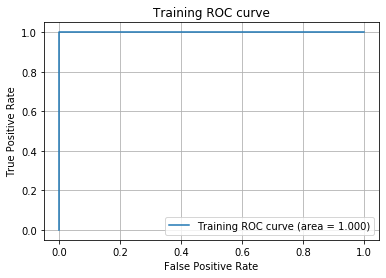

In [93]:
# Train AUC
train_predictions = lgbm.predict_proba(X_train, num_iteration=lgbm.best_iteration_)[:,1]
show_auc_roc(y_train, train_predictions, 'Training')

Validation AUC: 1.000


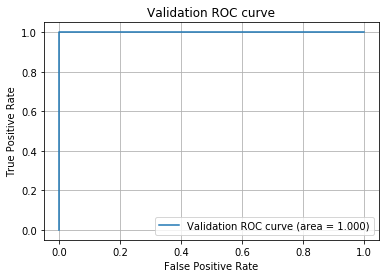

In [94]:
# Validation AUC
val_predictions = lgbm.predict_proba(X_val, num_iteration=lgbm.best_iteration_)[:,1]
show_auc_roc(y_val, val_predictions, 'Validation')

In [96]:
# Predict Test
test_preds = lgbm.predict(X_test, num_iteration=lgbm.best_iteration_)
show_scores(y_test, test_preds)

Confusion Matrix
true positive 2580, false positive: 51
false negative: 1662, true negative: 113815
Precision: 0.981, Recall: 0.608
F1 score: 0.751


Test AUC: 1.000


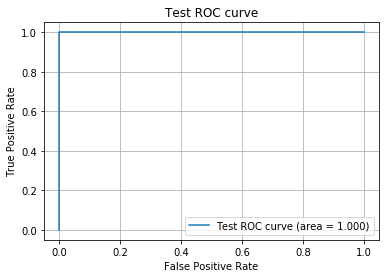

In [97]:
# Test AUC
test_predictions = lgbm.predict_proba(X_test, num_iteration=lgbm.best_iteration_)[:,1]
show_auc_roc(y_test, test_predictions, 'Test')